# Multi-dimensional 1559 Simulation

(adapted from 2021 / congestion 2.0)

2022S: we simulate the effects of multidimensional 1559 under 2 basefees.

We first import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import cProfile
import random

from importlib import reload

import simulator

In [10]:
reload(simulator)

<module 'simulator' from '/home/yan/Projects/camcos/simulations/simulator.py'>

# Create Demand Curve

We create a single demand curve and "standard" basefee so we can compare what happens to the same situation given different mechanisms. 

In [13]:
bf_standard_value = 38.100002694
bf_standard = simulator.Basefee(1.0/8, 15000000, 30000000, bf_standard_value) # d, target gas, max gas
# note our gas maxima are "real-life" amounts, but our actual gas per transaction is about 10x 
# bigger, for sake of simplicity

demand = simulator.Demand(2000, 300, 400, bf_standard_value)

# Basefee Over Time, Standard

We create a BasefeeSimulator() object, which has a simulate() method that runs a simulator for a certain number of turns. We run the simulation and save the summary data.

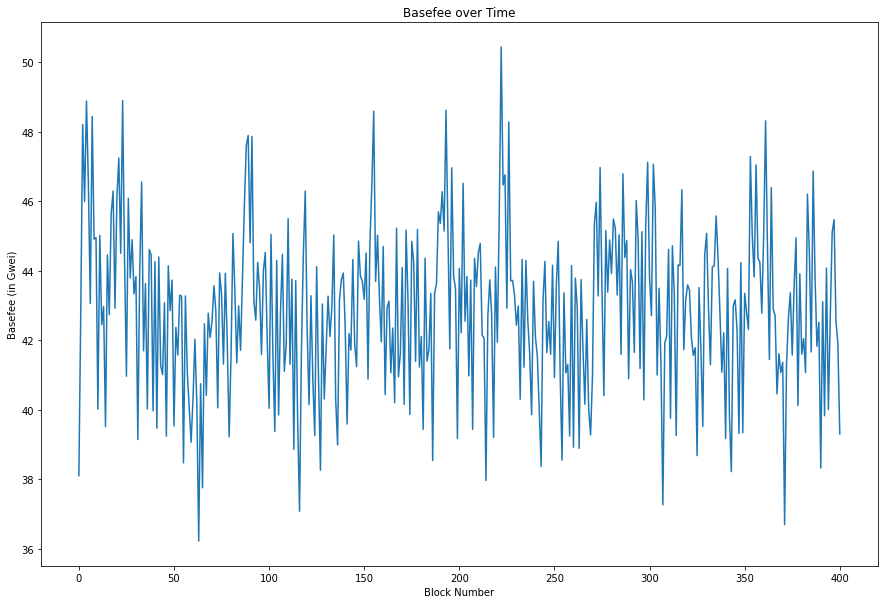

In [14]:
bf_sim = simulator.Simulator(bf_standard, ("gas",), (1.0,))
basefees_data, block_data, mempools_data = bf_sim.simulate(demand) # number of steps, and then initial basefee

plt.rcParams["figure.figsize"] = (15,10)
plt.title("Basefee over Time")
plt.xlabel("Block Number")
plt.ylabel("Basefee (in Gwei)")
plt.plot(basefees_data["gas"])

In [ ]:
%debug

> /home/yan/Projects/camcos/simulations/simulator.py(105)<listcomp>()
    103     """ Given a txn (DataFrame), compute the profit """
    104     txn = tx.to_dict()
--> 105     burn = sum([txn[r + " limit"] * self.basefee[r] for r in self.resources])
    106     return tx["total_value"] - burn
    107 



# Two completely Correlated Resources

We now start with our first mental experiment with Multidimensional EIP-1559. Now every transaction uses 2 resources; e.g. the first being our old gas limit for EVM computation and second being EVM storage. Each of these should have their own basefees. Also suppose on average that we want to price them at a ratio such as 3:1 (so 1/4 of the money on average is spent on storage, from a user perspective).

We should scale the price of these resources because in reality, supply and demand should balance (else we aren't really comparing apples to apples). So we should scale so the first (computational) resource is "used" 3/4 as much as the old gas limit was, and the second (storage) resource is "used" 1/4 as much. The *basefees* should however be identical.

Now, we want to simulate the first example where the two resources are completely correlated. It should be intuitive that this means

- the basefees rise and drop at the same time
- the resulting (added) basefees should have identical behavior as the old basefee.

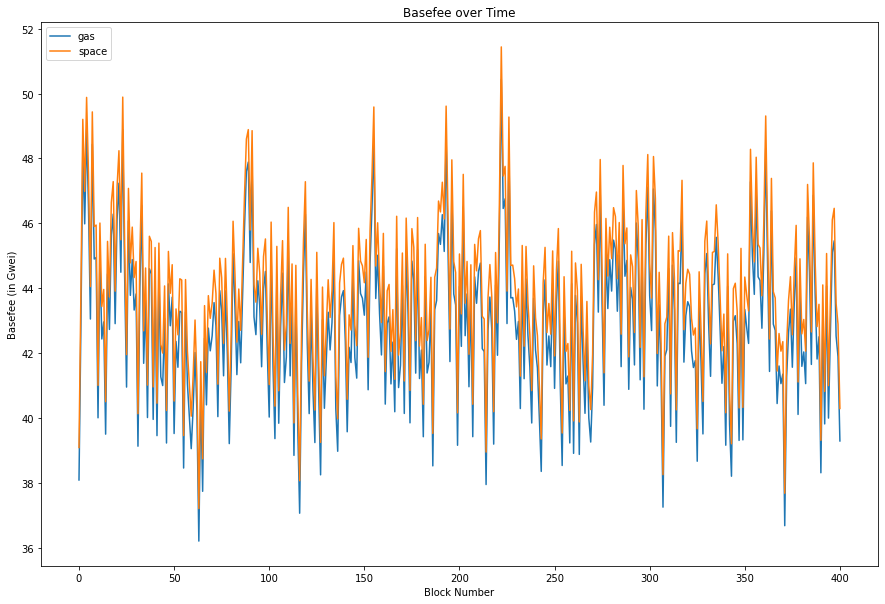

In [15]:
mbf_sim = simulator.Simulator(bf_standard, ("gas", "space"), (0.7, 0.3), resource_behavior="CORRELATED")
basefees_data, block_data, mempools_data = mbf_sim.simulate(demand)

plt.rcParams["figure.figsize"] = (15,10)
plt.title("Basefee over Time")
plt.xlabel("Block Number")
plt.ylabel("Basefee (in Gwei)")
plt.plot(basefees_data["gas"], label="gas")
basefees_data_space = [x+1 for x in basefees_data["space"]]
plt.plot(basefees_data_space, label="space")
plt.legend(loc="upper left")

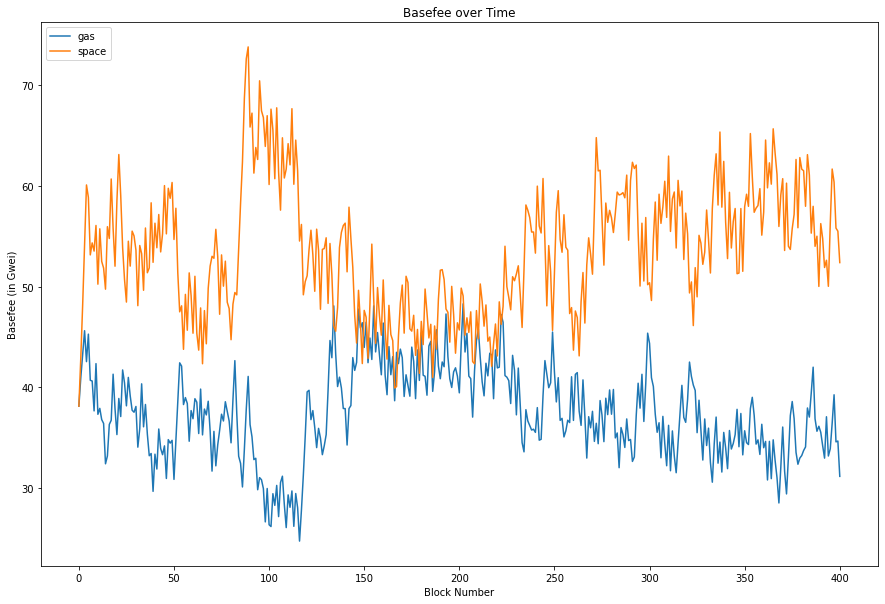

In [17]:
mbf_sim = simulator.Simulator(bf_standard, ("gas", "space"), (0.7, 0.3), resource_behavior="INDEPENDENT")
basefees_data, block_data, mempools_data = mbf_sim.simulate(demand)

plt.rcParams["figure.figsize"] = (15,10)
plt.title("Basefee over Time")
plt.xlabel("Block Number")
plt.ylabel("Basefee (in Gwei)")
plt.plot(basefees_data["gas"], label="gas")
plt.plot(basefees_data["space"], label="space")
plt.legend(loc="upper left")